In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
#sys.path.append('/gdrive/MyDrive/python/BayesianFiltering')
#sys.path.remove('/gdrive/MyDrive/python/BayesianFiltering')
sys.path

In [9]:
%cd gdrive/MyDrive/python/BayesianFiltering

/content/gdrive/MyDrive/python/BayesianFiltering


In [10]:
from ssm import StateSpaceModel
from ssm import LinearModelParameters
from SLDS import SLDS
from simulation import Simulation
from ssm import LGSSM
import numpy as np
import copy
from utils import Utils as u
import matplotlib.pyplot as plt

# Data Generation

## 1 dimensional model

In [11]:
a = np.array([0.1])
h = np.array([1])
q = np.array([0.01])
r = np.array([0.01])

params = LinearModelParameters(a, h, q, r)
model1 = LGSSM(1,1,params)
sim1 = Simulation(model1, T = 10, init_state=np.array([0]))

## 2 dimensional model

In [12]:
dx = 2
dy = 2
A = np.eye(dx)
H = 1 * np.eye(dy, dx)
Q = 1 * np.eye(dx)
R = 0.1 * np.eye(dy)

init_state = np.zeros([dx])
params2 = LinearModelParameters(A, H, Q, R)
model2 = LGSSM(dx, dy, params2)
sim2 = Simulation(model2, T = 100, init_state=init_state)

## SLDS

In [14]:
M = 5
dx = 2
dy = 2
var_max = 10
correl_mask_dx = np.ones([dx, dx]) - np.eye(dx)
model_parameter_array = np.empty([M], dtype=LinearModelParameters)
init_state = np.zeros([dx])
for m in range(M):
    A = np.eye(dx)
    H = 1 * np.eye(dy, dx)
    Q_nonsym = var_max * np.multiply(np.random.random([dx, dx]), np.eye(dx)) + \
              np.multiply(np.random.random([dx, dx]), correl_mask_dx)
    Q = 1 * (Q_nonsym + Q_nonsym.T)
    #Q = 10 * np.random.rand() * np.eye(dx)
    R = 1 * np.random.rand() * np.eye(dy)
    model_parameter_array[m] = LinearModelParameters(A, H, Q, R)


SLDS1 = SLDS(dx, dy, model_parameter_array)

alpha = np.random.choice(range(1, 50), M)
mat = np.random.dirichlet(alpha, M) # Random tranisiton matrix with Dirichlet(alpha) rows
SLDS1.set_transition_matrix(mat)

sim3 = Simulation(SLDS1, T = 100, init_state=[0, init_state])

# Filtering

## LGSSM 2D

In [13]:
# TODO: functionality for 1D
filt_model = copy.deepcopy(model2)
dx = filt_model.dx
dy = filt_model.dy
init = [np.zeros(dx), np.eye(dx)]
out = filt_model.kalman_filter(sim2.observs, init)
mean_pred = out[0]

## SLDS

### IMM

In [71]:
filt_slds_model = copy.deepcopy(SLDS1)
dx_slds = filt_slds_model.dx
init_slds = [np.zeros(dx_slds), np.eye(dx_slds)]
#out_slds = filt_slds_model.conditional_kalman_filter(sim3.states[0], sim3.observs, init_slds)
mean_out_IMM,cov_out_IMM = filt_slds_model.IMM(sim3.observs, init_slds)


### GPB

In [ ]:
filt_slds_model2 = copy.deepcopy(SLDS1)
dx_slds = filt_slds_model2.dx
init_slds = [np.zeros(dx_slds), np.eye(dx_slds)]
#out_slds = filt_slds_model.conditional_kalman_filter(sim3.states[0], sim3.observs, init_slds)
mean_out_GPB,cov_out_GPB = filt_slds_model.GPB(2, sim3.observs, init_slds)

# Plots

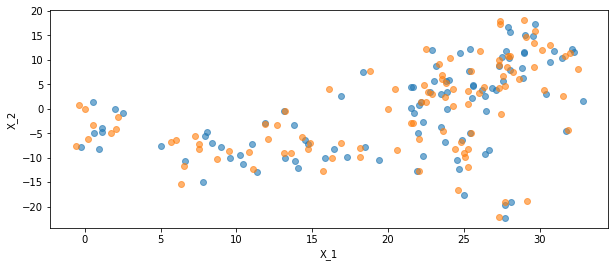

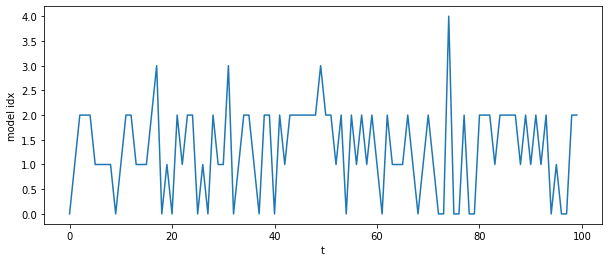

In [72]:
fig1, axes1 = plt.subplots(1, 1, sharex=True, figsize=(10, 4))
axes1.scatter(sim3.states[1][:, 0], sim3.states[1][:, 1], alpha=0.6)
axes1.scatter(mean_out_IMM[:, 0], mean_out_IMM[:, 1], alpha=0.6)
axes1.set_ylabel("X_2")
axes1.set_xlabel("X_1")
#
# fig2, axes2 = plt.subplots(1, 1, sharex=True, figsize=(10, 4))
# axes1.scatter(mean_pred[:, 0], mean_pred[:, 1], alpha=0.6)
# axes2.set_ylabel("X_est_2")
# axes2.set_xlabel("X_est_1")
#
fig3, axes3 = plt.subplots(1, 1, sharex=True, figsize=(10, 4))
axes3.plot(sim3.states[0])
axes3.set_ylabel("model idx")
axes3.set_xlabel("t")

# axes[1,0].plot(model1.states[:,0])
# axes[1,0].plot(model1.observs[:,0])
# axes[1,0].set_xlabel("t");
# axes[1,0].set_ylabel("X1,X2");
# axes[1,1].plot(model.observs[:,0])
# axes[1,1].plot(model.observs[:,1])
# axes[1,1].set_xlabel("t");
# axes[1,1].set_ylabel("Y1,Y2");
#

plt.show()